Mean NDVI (2023): 0.36274838928864117
Mean NDVI (2025): 0.3397256996879802
Computed NDVI ratio threshold (2025 / 2023): 0.9365326207352457


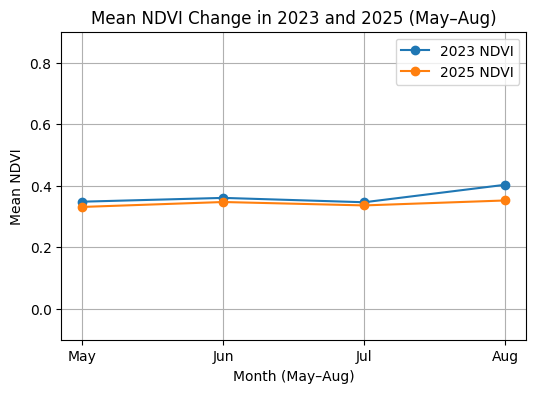

Band count: 40
['B4_May_2023', 'B3_May_2023', 'B2_May_2023', 'B8_May_2023', 'B4_Jun_2023', 'B3_Jun_2023', 'B2_Jun_2023', 'B8_Jun_2023', 'B4_Jul_2023', 'B3_Jul_2023', 'B2_Jul_2023', 'B8_Jul_2023', 'B4_Aug_2023', 'B3_Aug_2023', 'B2_Aug_2023', 'B8_Aug_2023', 'NDVI_May_2023', 'NDVI_Jun_2023', 'NDVI_Jul_2023', 'NDVI_Aug_2023', 'B4_May_2025', 'B3_May_2025', 'B2_May_2025', 'B8_May_2025', 'B4_Jun_2025', 'B3_Jun_2025', 'B2_Jun_2025', 'B8_Jun_2025', 'B4_Jul_2025', 'B3_Jul_2025', 'B2_Jul_2025', 'B8_Jul_2025', 'B4_Aug_2025', 'B3_Aug_2025', 'B2_Aug_2025', 'B8_Aug_2025', 'NDVI_May_2025', 'NDVI_Jun_2025', 'NDVI_Jul_2025', 'NDVI_Aug_2025']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Skipping healthy_patch_000 (already exists)
Skipping healthy_patch_001 (already exists)
Skipping healthy_patch_002 (already exists)
Skipping healthy_patch_003 (already exists)
Skipping healthy_patch_004 (already exists)
Skipping healthy_patch_005 (already exists)
Skipping healthy_patch_006 (already exists)
Skipping healthy_patch_007 (already exists)
Skipping healthy_patch_008 (already exists)
Skipping healthy_patch_009 (already exists)
Skipping healthy_patch_010 (already exists)
Skipping healthy_patch_011 (already exists)
Skipping healthy_patch_012 (already exists)
Skipping healthy_patch_013 (already exists)
Skipping healthy_patch_014 (already exists)
Skipping healthy_patch_015 (already exists)
Skipping healthy_patch_016 (already exists)
Skipping healthy_patch_017 (already exists)
Skipping healthy_patch_018 (already exists)
Skipping healthy_patch_019 (already exists)
Skipping healthy_patch_020 (already exists)
Skipping healthy_patch_021 (already exists)
Skipping healthy_patch_022 (alre

In [ ]:
import ee
import geemap
import time

# Authenticate and initialize from Google Earth Engine
ee.Authenticate()
ee.Initialize(project='mdfakhrulalamsajib')

# ROI for Coconino National Forest
ASSET_ID = 'projects/mdfakhrulalamsajib/assets/AdministrativeForest_ExportFeatures'

# Earth Engine can adjust the boundary up to 100 meters to keep geometry valid.
# It does not change the forest area.
# It only helps Earth Engine handle complex shapes.
def define_roi():
    fc = ee.FeatureCollection(ASSET_ID)
    roi = (fc.filter(ee.Filter.eq('FORESTNAME', 'Coconino National Forest'))
             .geometry()
             .buffer(0, 100))  # clean geometry, no shape change
    return roi


# Sentinel-2 SR: cloud + land masking
def mask_sentinel2(image):
    qa = image.select('QA60')
    scl = image.select('SCL')

    cloud_ok = qa.bitwiseAnd(1 << 10).eq(0)   # opaque clouds bit = 0
    cirrus_ok = qa.bitwiseAnd(1 << 11).eq(0)  # cirrus bit = 0
    clear = cloud_ok.And(cirrus_ok)

    land = scl.eq(4).Or(scl.eq(5))

    return (image.updateMask(clear)
                 .updateMask(land)
                 .copyProperties(image, ["system:time_start"]))


# Monthly median mosaic with fixed band names + year
def get_monthly_mosaic(start_date, end_date, mon_suffix, year_suffix, roi):
    img = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(roi)
           .filterDate(start_date, end_date)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
           .map(mask_sentinel2)
           .median()
           .select(['B4', 'B3', 'B2', 'B8'])
           .rename([f'B4_{mon_suffix}_{year_suffix}',
                    f'B3_{mon_suffix}_{year_suffix}',
                    f'B2_{mon_suffix}_{year_suffix}',
                    f'B8_{mon_suffix}_{year_suffix}']))
    return img


# https://developers.google.com/earth-engine/apidocs/ee-imagecollection-filterdate#colab-python

# Feature stack + NDVI mean ratio (2025 / 2023)
# Create per-pixel NDVI maps, compute stress proxy, and export labeled patches
# Per-pixel (for learning)
# Images for modeling

def build_feature_stack(roi):
    # 2023 (May–Aug)  [end date is exclusive]
    may_2023 = get_monthly_mosaic('2023-05-01', '2023-06-01', 'May', '2023', roi)
    jun_2023 = get_monthly_mosaic('2023-06-01', '2023-07-01', 'Jun', '2023', roi)
    jul_2023 = get_monthly_mosaic('2023-07-01', '2023-08-01', 'Jul', '2023', roi)
    aug_2023 = get_monthly_mosaic('2023-08-01', '2023-09-01', 'Aug', '2023', roi)

    spectral_2023 = (may_2023.addBands(jun_2023).addBands(jul_2023).addBands(aug_2023)).multiply(0.0001)

    ndvi_may_2023 = may_2023.normalizedDifference(['B8_May_2023', 'B4_May_2023']).rename('NDVI_May_2023')
    ndvi_jun_2023 = jun_2023.normalizedDifference(['B8_Jun_2023', 'B4_Jun_2023']).rename('NDVI_Jun_2023')
    ndvi_jul_2023 = jul_2023.normalizedDifference(['B8_Jul_2023', 'B4_Jul_2023']).rename('NDVI_Jul_2023')
    ndvi_aug_2023 = aug_2023.normalizedDifference(['B8_Aug_2023', 'B4_Aug_2023']).rename('NDVI_Aug_2023')

    mean_ndvi_2023 = (ee.ImageCollection([
        ndvi_may_2023.rename('NDVI'),
        ndvi_jun_2023.rename('NDVI'),
        ndvi_jul_2023.rename('NDVI'),
        ndvi_aug_2023.rename('NDVI')
    ]).mean().rename('NDVI_mean_2023'))

    #  2025 (May–Aug)  [end date is exclusive]
    may_2025 = get_monthly_mosaic('2025-05-01', '2025-06-01', 'May', '2025', roi)
    jun_2025 = get_monthly_mosaic('2025-06-01', '2025-07-01', 'Jun', '2025', roi)
    jul_2025 = get_monthly_mosaic('2025-07-01', '2025-08-01', 'Jul', '2025', roi)
    aug_2025 = get_monthly_mosaic('2025-08-01', '2025-09-01', 'Aug', '2025', roi)

    spectral_2025 = (may_2025.addBands(jun_2025).addBands(jul_2025).addBands(aug_2025)).multiply(0.0001)

    ndvi_may_2025 = may_2025.normalizedDifference(['B8_May_2025', 'B4_May_2025']).rename('NDVI_May_2025')
    ndvi_jun_2025 = jun_2025.normalizedDifference(['B8_Jun_2025', 'B4_Jun_2025']).rename('NDVI_Jun_2025')
    ndvi_jul_2025 = jul_2025.normalizedDifference(['B8_Jul_2025', 'B4_Jul_2025']).rename('NDVI_Jul_2025')
    ndvi_aug_2025 = aug_2025.normalizedDifference(['B8_Aug_2025', 'B4_Aug_2025']).rename('NDVI_Aug_2025')

    mean_ndvi_2025 = (ee.ImageCollection([
        ndvi_may_2025.rename('NDVI'),
        ndvi_jun_2025.rename('NDVI'),
        ndvi_jul_2025.rename('NDVI'),
        ndvi_aug_2025.rename('NDVI')
    ]).mean().rename('NDVI_mean_2025'))

    # Compute scalar means over ROI
    mean_ndvi_2023_value = mean_ndvi_2023.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    mean_ndvi_2025_value = mean_ndvi_2025.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )

    mean_2023 = ee.Number(mean_ndvi_2023_value.get('NDVI_mean_2023'))
    mean_2025 = ee.Number(mean_ndvi_2025_value.get('NDVI_mean_2025'))

    print("Mean NDVI (2023):", mean_2023.getInfo())
    print("Mean NDVI (2025):", mean_2025.getInfo())

    # Compute the overall NDVI ratio threshold
    # This is a single number, not an image.
    # It’s the average NDVI ratio for the whole region (ROI).
    # it’s one overall value, a baseline or reference.
    # NDVI ratio average for the whole region
    ratio_threshold = mean_2025.divide(mean_2023)
    print("Computed NDVI ratio threshold (2025 / 2023):", ratio_threshold.getInfo())

    # Compute a per-pixel NDVI ratio map
    # NDVI ratio for each pixel
    # This creates a map (image) where each pixel has its own NDVI ratio.
    # It tells you how much each pixel’s vegetation changed comparing 2023 and 2025 only
    # (Pixel A, ratio = 0.8, Pixel B ratio = 0.6 , it’s per-pixel data, spatially detailed.)
    denom_ok = mean_ndvi_2023.gte(0.1)
    ratio_2025_2023 = mean_ndvi_2025.updateMask(denom_ok) \
                        .divide(mean_ndvi_2023.updateMask(denom_ok)) \
                        .rename('NDVI_ratio_2025_2023')

    # Apply stress map using dynamic threshold
    # Mark pixels as stressed if their ratio is lower than the region’s average ratio.
    stress_proxy = ratio_2025_2023.lt(ratio_threshold).rename('stress_proxy')

    # Feature stack
    features_2023 = spectral_2023.addBands([ndvi_may_2023, ndvi_jun_2023, ndvi_jul_2023, ndvi_aug_2023])
    features_2025 = spectral_2025.addBands([ndvi_may_2025, ndvi_jun_2025, ndvi_jul_2025, ndvi_aug_2025])

    feature_image = (features_2023
                     .addBands(features_2025)
                     .toFloat()
                     .unmask(-9999)
                     .clip(roi))

    label_raster = stress_proxy.unmask(0).toFloat()
    return feature_image, label_raster

#  Create Patch Grid
# 64×64 patches preserve spatial structure for model learning
def create_patch_grid(aoi, patch_size=64, scale=10):
    patch_m = patch_size * scale
    # co-registration
    # Earth Engine automatically ensures all images are in the same CRS(Coordinate Reference System) (e.g., EPSG:3857)
    # Convert ROI from lat/lon (EPSG:4326) to meters (EPSG:3857) for clean 64x64 meter tiles.
    # maxError=10 just lets Earth Engine slightly simplify the geometry to speed up reprojection.
    # Map in degrees (4326): looks fine, but hard to measure exact patch size
    # Map in meters (3857): makes perfect 640 m × 640 m tiles
    aoi_proj = aoi.transform('EPSG:3857', maxError=10)
    return aoi_proj.coveringGrid('EPSG:3857', patch_m)


# Annotate Grid with Class Count and Label
# reduceRegion summarizes pixel values within a specified geometry using a reducer.
# reduceRegion computes the mean stress value inside each 64×64 patch
# Since the label image is binary, the mean corresponds to the fraction of stressed pixels in that patch.
def annotate_grid(grid, label_raster):
    # use an integer view for stats only
    label_int = label_raster.round().toInt().rename('label')

    def annotate(feature):
        stats = label_int.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e8
        )
        hist = ee.Dictionary(stats.get('label'))
        class_count = hist.size()

        mean = label_int.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e8
        )
        avg = ee.Number(mean.get('label'))  # 0..1
        label = ee.Algorithms.If(avg.gte(0.5), 1, 0)

        return feature.set({
            'class_count': class_count,
            'majority_label': label
        })
    return grid.map(annotate)


#Export Patch Function

def export_patch(feature, image, label_raster, index, label_str, folder='Sentinel2_Export_23_25'):
    geom = feature.geometry(proj='EPSG:3857')

    out = (image.reproject('EPSG:3857', None, 10)
            .addBands(label_raster.reproject('EPSG:3857', None, 10).rename('label'))
            .toFloat())


    file_prefix = f"{label_str}_patch_{index:03d}"  # index-based naming stays same
    desc = file_prefix

    task = ee.batch.Export.image.toDrive(
        image=out,
        description=desc,
        region=geom,
        scale=10,
        crs='EPSG:3857',
        maxPixels=1e8,
        folder=folder,
        fileFormat='GeoTIFF'

    )

    task.start()
    print(f"Exported {file_prefix} (image + label together)")


#Main
roi = define_roi()
image, label_raster = build_feature_stack(roi)

# NDVI time-series (May–Aug for 2023 & 2025)
import matplotlib.pyplot as plt
# Calculate mean NDVI per month to visualize vegetation trend
# Numbers for plotting
# Per-region mean (for understanding trends)

def monthly_ndvi_mean(start, end, mon, yr):
    im = get_monthly_mosaic(start, end, mon, yr, roi)
    ndvi = im.normalizedDifference([f'B8_{mon}_{yr}', f'B4_{mon}_{yr}']).rename('NDVI')
    # keep only valid NDVI range
    ndvi = ndvi.updateMask(ndvi.gte(-1).And(ndvi.lte(1)))
    d = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    return d.get('NDVI').getInfo()

months = ['May','Jun','Jul','Aug']
ranges_2023 = [('2023-05-01','2023-06-01'),
               ('2023-06-01','2023-07-01'),
               ('2023-07-01','2023-08-01'),
               ('2023-08-01','2023-09-01')]
ranges_2025 = [('2025-05-01','2025-06-01'),
               ('2025-06-01','2025-07-01'),
               ('2025-07-01','2025-08-01'),
               ('2025-08-01','2025-09-01')]

ndvi_2023_values = [monthly_ndvi_mean(a,b,m,'2023') for (a,b), m in zip(ranges_2023, months)]
ndvi_2025_values = [monthly_ndvi_mean(a,b,m,'2025') for (a,b), m in zip(ranges_2025, months)]


plt.figure(figsize=(6,4))
plt.plot(months, ndvi_2023_values, marker='o', label='2023 NDVI')
plt.plot(months, ndvi_2025_values, marker='o', label='2025 NDVI')
plt.xlabel('Month (May–Aug)')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI Change in 2023 and 2025 (May–Aug)')
plt.ylim(-0.1, 0.9)  # optional, keeps NDVI in a sensible range
plt.legend()
plt.grid(True)
plt.savefig('mean_ndvi_change_2023_2025.png', dpi=300, bbox_inches='tight')
plt.show()

print('Band count:', image.bandNames().size().getInfo())
print(image.bandNames().getInfo())

# Generate grid and annotate
# Generate grid and keep only tiles fully inside the forest polygon
# (shrink by 5 m so tiles touching the edge are excluded)

roi_interior = roi.buffer(-5, 100)  # shrink by ~5 m
grid = (create_patch_grid(roi)
          .filterBounds(roi_interior)
          .filter(ee.Filter.contains(leftValue=roi_interior, rightField='.geo'))
          .limit(3000))

annotated_grid = annotate_grid(grid, label_raster)

# all_grid = create_patch_grid(roi)
# print('Total grid tiles:', all_grid.size().getInfo())
# print('Tiles fully inside:', grid.size().getInfo())


# Filter annotated patches (at least one class present)
single_class = annotated_grid.filter(ee.Filter.gte('class_count', 1))

# Add 'purity' (1 - mean stress_proxy) to each patch
def annotate_with_purity(feature):
    mean = label_raster.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10,
        maxPixels=1e8
    )
    purity = ee.Number(1.0).subtract(ee.Number(mean.get('stress_proxy')))
    return feature.set({'purity': purity})

# Apply purity annotation
annotated_with_purity = single_class.map(annotate_with_purity)

# Healthy patches are ≥ 60% pure (mostly green vegetations)
# Only high-purity patches (≥60% class consistency) were exported for training.
healthy = annotated_with_purity.filter(ee.Filter.eq('majority_label', 0))\
                               .filter(ee.Filter.gte('purity', 0.6))\
                               .limit(300)

# # Stressed patches are ≤ 40% green (clearly red or dry).
stressed = annotated_with_purity.filter(ee.Filter.eq('majority_label', 1))\
                                 .filter(ee.Filter.lte('purity', 0.4))\
                                 .limit(300)


# print("Healthy single-class patches:", healthy.size().getInfo())
# print("Stressed single-class patches:", stressed.size().getInfo())

#Export
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# patch export folder
EXPORT_FOLDER = "/content/drive/MyDrive/Sentinel2_Export_23_25"

def already_exported(file_prefix):
    # single combined TIFF now
    return os.path.exists(os.path.join(EXPORT_FOLDER, f"{file_prefix}.tif"))


def export_patches(patch_fc, label_str):
    patch_list = patch_fc.toList(patch_fc.size())
    for i in range(patch_fc.size().getInfo()):
        file_prefix = f"{label_str}_patch_{i:03d}"
        if already_exported(file_prefix):
            print(f"Skipping {file_prefix} (already exists)")
            continue

        feature = ee.Feature(patch_list.get(i))
        export_patch(feature, image, label_raster, i, label_str)
        time.sleep(10)

export_patches(healthy, "healthy")
export_patches(stressed, "stressed")


In [ ]:
# 300 × 0.7 = 210 (train per class)
#300 × 0.1 = 30  (val per class)
# Remaining 60 (test per class)

from google.colab import drive
import os, random, shutil

# Mount Drive
drive.mount('/content/drive')

# Base folder (raw data)
source_folder = "/content/drive/MyDrive/Sentinel2_Export_23_25"

# New folder for splits
base_folder = "/content/drive/MyDrive/Sentinel2_Split_23_25"

# Create split subfolders
splits = ["train", "val", "test"]
classes = ["healthy", "stressed"]
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_folder, split, cls), exist_ok=True)

#  List only top-level .tif files from the RAW folder
root_tifs = [
    f for f in os.listdir(source_folder)
    if f.endswith(".tif") and os.path.isfile(os.path.join(source_folder, f))
]

# Separate by class using filename prefixes
healthy_files = [f for f in root_tifs if f.lower().startswith("healthy")]
stressed_files = [f for f in root_tifs if f.lower().startswith("stressed")]

print(f"Found {len(healthy_files)} healthy and {len(stressed_files)} stressed files at root.\n")

# Reproducible shuffle
random.seed(42)
random.shuffle(healthy_files)
random.shuffle(stressed_files)

def split_70_10_20(file_list):
    n = len(file_list)
    n_train = int(n * 0.7)
    n_val = int(n * 0.1)
    # remaining go to test
    return (
        file_list[:n_train],
        file_list[n_train:n_train + n_val],
        file_list[n_train + n_val:]
    )

healthy_train, healthy_val, healthy_test = split_70_10_20(healthy_files)
stressed_train, stressed_val, stressed_test = split_70_10_20(stressed_files)

def copy_if_missing(files, cls, split):
    copied, skipped = 0, 0
    dest_dir = os.path.join(base_folder, split, cls)
    for name in files:
        src = os.path.join(source_folder, name)   # copy from RAW folder
        dst = os.path.join(dest_dir, name)
        if os.path.exists(dst):
            skipped += 1
            continue
        shutil.copy2(src, dst)
        copied += 1
    return copied, skipped


stats = {}

# Copy per class per split (idempotent)
for cls, groups in {
    "healthy": (healthy_train, healthy_val, healthy_test),
    "stressed": (stressed_train, stressed_val, stressed_test),
}.items():
    for split, files in zip(["train", "val", "test"], groups):
        c, s = copy_if_missing(files, cls, split)
        stats[(cls, split)] = (c, s)

# Summary table
print("=== Dataset split summary (files currently in each folder) ===")
print("{:<8} {:>10} {:>10} {:>10}".format("Split", "Healthy", "Stressed", "Total"))
for split in ["train", "val", "test"]:
    healthy_count = len([
        f for f in os.listdir(os.path.join(base_folder, split, "healthy"))
        if f.endswith(".tif")
    ])
    stressed_count = len([
        f for f in os.listdir(os.path.join(base_folder, split, "stressed"))
        if f.endswith(".tif")
    ])
    total = healthy_count + stressed_count
    print("{:<8} {:>10} {:>10} {:>10}".format(split, healthy_count, stressed_count, total))

# Extra safety: check that no file is in more than one split
print("\n=== Verifying that no file appears in multiple splits ===")
file_locations = {}  # filename -> list of (split, class)

for split in splits:
    for cls in classes:
        folder = os.path.join(base_folder, split, cls)
        for f in os.listdir(folder):
            if not f.endswith(".tif"):
                continue
            key = f
            where = f"{split}/{cls}"
            if key not in file_locations:
                file_locations[key] = []
            file_locations[key].append(where)

duplicates = {k: v for k, v in file_locations.items() if len(v) > 1}

if not duplicates:
    print(" No duplicates found. Each .tif file is present in at most one split.")
else:
    print(" Warning: some files appear in multiple splits:")
    for fname, locs in duplicates.items():
        print(f"  {fname}: {locs}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 300 healthy and 300 stressed files at root.

=== Dataset split summary (files currently in each folder) ===
Split       Healthy   Stressed      Total
train           210        210        420
val              30         30         60
test             60         60        120

=== Verifying that no file appears in multiple splits ===
 No duplicates found. Each .tif file is present in at most one split.


In [1]:
!pip install rasterio

Mounted at /content/drive
Loading train/val/test datasets from split folders...
Train loaded: 420 (healthy=210, stressed=210, skipped=0)
Val loaded: 60 (healthy=30, stressed=30, skipped=0)
Test loaded: 120 (healthy=60, stressed=60, skipped=0)
Building CNN model...
Training CNN...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.8325 - loss: 0.4562 - val_accuracy: 0.9167 - val_loss: 0.3094
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9192 - loss: 0.2832 - val_accuracy: 0.9333 - val_loss: 0.2972
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9243 - loss: 0.2685 - val_accuracy: 0.9333 - val_loss: 0.2578
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9103 - loss: 0.2586 - val_accuracy: 0.9333 - val_loss: 0.2642
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9154 - loss: 0.2580 - val_accuracy: 0.9500 - val_loss: 0.2655
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9182 - loss: 0

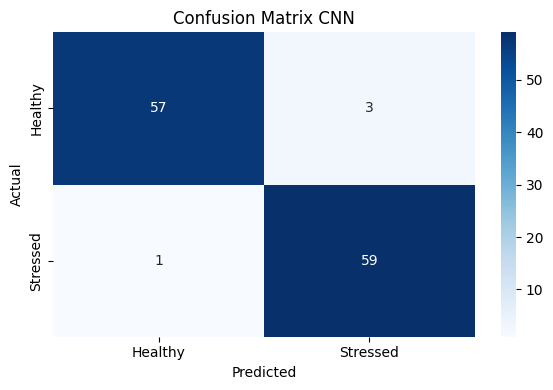

In [ ]:
# CNN-based Detection of Vegetation Stress from Satellite Imagery
# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# Number of batches = ceil(total samples​/batch_size)
# 420 / 8 = 52.5 -> round up -> 53 batches

# pip install numpy tensorflow rasterio scikit-learn pandas

import os
import random
import numpy as np
from glob import glob
SEED = 42
# Environment-level determinism
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# Python & NumPy seeds
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label
BATCH_SIZE    = 8   # Model studies 8 images together at one time
EPOCHS        = 15   #Train the model on the entire dataset 15 times


splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]


# Helper: list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths


# Loader: read 1..40 as features, 41 as label
def load_single_patch(tif_path):
    import numpy as np, rasterio, os

    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    # Safety check: sometimes we might still have crazy negative values.
    # Any value below -1000 is treated as invalid and replaced by 0.
    # This helps clean up any unexpected artifacts.

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to reasonable ranges
    # Matches my preprocessing where we scaled reflectance and NDVI ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # Majority label from label band
    # It checks which pixels are stressed, counts them, divides by total pixels, and converts the result to a float
    stressed_fraction = (label_band_hw >= 0.5).mean()
    label_binary = 1 if stressed_fraction >= 0.5 else 0

    # CHW to HWC
    # Right now features are (C, H, W) = (40, 64, 64).
    # transpose(1, 2, 0) to (H, W, C) = (64, 64, 40).
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)

    # if (height, width) != (64, 64)
    # Take the first two elements of the shape tuple.
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc, label_binary


# Build in-memory dataset for a split
def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)  # ensure same order every run
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "-", exception)

    label_values = [label for _, label in dataset_list]
    count_healthy = label_values.count(0)
    count_stressed = label_values.count(1)
    print(
        f"{split_name.capitalize()} loaded: {len(dataset_list)} "
        f"(healthy={count_healthy}, stressed={count_stressed}, skipped={skipped_count})"
    )

    return dataset_list


# Convert list of (image, label) into tf.data.Dataset
def create_tf_dataset(pairs_list):
    image_list = [image_array for image_array, _ in pairs_list]
    label_list = [label_value for _, label_value in pairs_list]

    image_array_all = np.asarray(image_list, dtype=np.float32)
    label_array_all = np.asarray(label_list, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_array_all, label_array_all))
    dataset = dataset.shuffle(2 * BATCH_SIZE, seed=SEED, reshuffle_each_iteration=False)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset



# CNN model
def build_cnn_model(input_shape, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Rescaling(1.0),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# Main: load data, train, evaluate
print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = create_tf_dataset(train_pairs)
val_dataset   = create_tf_dataset(val_pairs)

print("Building CNN model...")
input_shape = (PATCH_HEIGHT, PATCH_WIDTH, NUM_BANDS)
cnn_model = build_cnn_model(input_shape=input_shape, dropout_rate=0.30)

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training CNN...")
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1   # show me a progress bar during training.
)


# Evaluation on test set
print("Evaluating on test set...")

test_images = np.stack([image_array for image_array, _ in test_pairs], axis=0)
test_labels = np.array([label_value for _, label_value in test_pairs], dtype=int)

probabilities = cnn_model.predict(test_images, batch_size=BATCH_SIZE).ravel()
predicted_labels = (probabilities >= 0.5).astype(int)
accuracy_value  = accuracy_score(test_labels, predicted_labels)
precision_value = precision_score(test_labels, predicted_labels, zero_division=0)
recall_value    = recall_score(test_labels, predicted_labels, zero_division=0)
f1_value        = f1_score(test_labels, predicted_labels, zero_division=0)
confusion_mat   = confusion_matrix(test_labels, predicted_labels)

metrics_dataframe = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score":  [accuracy_value, precision_value, recall_value, f1_value]
})

print("\nFinal evaluation metrics:")
print(metrics_dataframe.to_string(index=False))
print("\nConfusion Matrix:\n", confusion_mat)

#plot and save confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Stressed"],
            yticklabels=["Healthy", "Stressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix CNN")
plt.tight_layout()
plt.savefig("confusion_matrix_CNN.png", dpi=300)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Loading train/val/test datasets from split folders...
Train loaded: 420 (healthy=210, stressed=210, skipped=0)
Val loaded: 60 (healthy=30, stressed=30, skipped=0)
Test loaded: 120 (healthy=60, stressed=60, skipped=0)
Building Vision Transformer model...
Training Vision Transformer...
Epoch [1/15] Train Loss: 0.4544 | Val Loss: 0.3528
Epoch [2/15] Train Loss: 0.3214 | Val Loss: 0.2631
Epoch [3/15] Train Loss: 0.3101 | Val Loss: 0.2553
Epoch [4/15] Train Loss: 0.2898 | Val Loss: 0.2380
Epoch [5/15] Train Loss: 0.2938 | Val Loss: 0.2896
Epoch [6/15] Train Loss: 0.2814 | Val Loss: 0.3393
Epoch [7/15] Train Loss: 0.3226 | Val Loss: 0.2338
Epoch [8/15] Train Loss: 0.2759 | Val Loss: 0.3520
Epoch [9/15] Train Loss: 0.2891 | Val Loss: 0.2270
Epoch [10/15] Train Loss: 0.2732 | Val Loss: 0.2015
Epoch [11/15] Train Loss: 0.2575 | Val Loss: 0.2860
Epoch

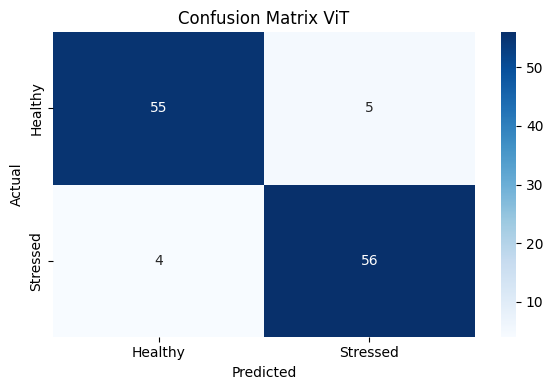

In [ ]:
#  Vision Transformer Vegetation Stress Detection from Satellite Imagery (PyTorch ViT)
# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# pip install torch torchvision numpy rasterio scikit-learn pandas

# Input patch: 64×64 pixels
# Patch size: 8x8 pixels


# import os
# import random
# import numpy as np
# import torch

# # Reproducibility
# SEED = 42
# os.environ['PYTHONHASHSEED'] = str(SEED)
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# import rasterio
# from sklearn.metrics import r2_score
# import pandas as pd
# import random
# import matplotlib.pyplot as plt
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

import os
from glob import glob
import numpy as np
import torch
# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# CuDNN determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import random
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label (1-based index)
BATCH_SIZE    = 8
EPOCHS        = 15


splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Helper: list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths


# Loader: read 1..40 as features, 41 as label (majority)
def load_single_patch(tif_path):
    import numpy as np, rasterio, os

    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to reasonable ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # Majority label from label band
    stressed_fraction = (label_band_hw >= 0.5).mean()
    label_binary = 1 if stressed_fraction >= 0.5 else 0

    # CHW to HWC for storage; will convert to CHW in Dataset
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc.astype("float32"), label_binary


# Build in-memory dataset for a split
def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "->", exception)

    label_values = [label for _, label in dataset_list]
    count_healthy = label_values.count(0)
    count_stressed = label_values.count(1)
    print(
        f"{split_name.capitalize()} loaded: {len(dataset_list)} "
        f"(healthy={count_healthy}, stressed={count_stressed}, skipped={skipped_count})"
    )

    return dataset_list


# PyTorch Dataset
class PatchDataset(Dataset):
    def __init__(self, pairs_list):
        self.image_list = [image_array for image_array, _ in pairs_list]
        self.label_list = [label_value for _, label_value in pairs_list]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_array = self.image_list[index]          # H, W, C
        label_value = self.label_list[index]

        # Convert to tensor, HWC to CHW
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)  # C, H, W
        label_tensor = torch.tensor(label_value, dtype=torch.float32)

        return image_tensor, label_tensor


# Vision Transformer components
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_ratio=2.0, dropout_rate=0.3):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=False  # expects (seq_len, batch, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        hidden_dim = int(embedding_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),    # Gaussian Error Linear Unit (GELU), smoother and more stable gradient flow
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embedding_dim),
        )

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (batch, num_patches, embedding_dim)
        residual = x
        x_norm = self.norm1(x)
        # MultiheadAttention expects (seq_len, batch, embed_dim)
        x_transposed = x_norm.transpose(0, 1)  # (num_patches, batch, embedding_dim)
        attention_output, _ = self.attention(x_transposed, x_transposed, x_transposed)
        attention_output = attention_output.transpose(0, 1)  # back to (batch, num_patches, embedding_dim)
        x = residual + self.dropout(attention_output)

        residual2 = x
        x_norm2 = self.norm2(x)
        mlp_output = self.mlp(x_norm2)
        x = residual2 + self.dropout(mlp_output)
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
                 image_height,
                 image_width,
                 num_channels,
                 patch_size=8,
                 embedding_dim=64,
                 num_layers=4,
                 num_heads=4,
                 mlp_ratio=2.0,
                 dropout_rate=0.3,
                 mlp_head_units=(128, 64)):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.num_channels = num_channels
        self.patch_size = patch_size

        assert image_height % patch_size == 0 and image_width % patch_size == 0, \
            "Image size must be divisible by patch size."

        self.num_patches_h = image_height // patch_size
        self.num_patches_w = image_width // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        # Patch embedding via Conv2d
        self.patch_embedding = nn.Conv2d(
            in_channels=num_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Positional embeddings
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.num_patches, embedding_dim)
        )

        # Transformer encoder blocks
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embedding_dim)

        # Classification head
        mlp_head = []
        current_dim = embedding_dim
        for units in mlp_head_units:
            mlp_head.append(nn.Linear(current_dim, units))
            mlp_head.append(nn.ReLU())
            mlp_head.append(nn.Dropout(dropout_rate))
            current_dim = units
        mlp_head.append(nn.Linear(current_dim, 1))  # single logit for binary classification
        self.mlp_head = nn.Sequential(*mlp_head)

    def forward(self, images):
        # images: (batch, C, H, W)
        x = self.patch_embedding(images)  # (batch, embedding_dim, H/ps, W/ps)
        batch_size, embedding_dim, patches_h, patches_w = x.shape
        x = x.reshape(batch_size, embedding_dim, patches_h * patches_w)
        x = x.permute(0, 2, 1)  # (batch, num_patches, embedding_dim)

        x = x + self.position_embeddings  # add positional info

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)

        x = self.norm(x)

        # Global average pooling over patches
        x = x.mean(dim=1)  # (batch, embedding_dim)

        logits = self.mlp_head(x)  # (batch, 1)
        return logits


# Load data
print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = PatchDataset(train_pairs)
val_dataset   = PatchDataset(val_pairs)
test_dataset  = PatchDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# Build Vision Transformer model
print("Building Vision Transformer model...")
vit_model = VisionTransformer(
    image_height=PATCH_HEIGHT,
    image_width=PATCH_WIDTH,
    num_channels=NUM_BANDS,
    patch_size=8,
    embedding_dim=64,
    num_layers=4,
    num_heads=4,
    mlp_ratio=3.0,
    dropout_rate=0.30,
    mlp_head_units=(128, 64)
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-3)

# Training loop with early stopping
best_val_loss = float("inf")
epochs_without_improvement = 0
best_model_state = None

print("Training Vision Transformer...")

for epoch_index in range(EPOCHS):
    vit_model.train()
    running_train_loss = 0.0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).unsqueeze(1)  # (batch, 1)

        optimizer.zero_grad()
        logits = vit_model(batch_images)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_images.size(0)

    average_train_loss = running_train_loss / len(train_dataset)

    # Validation
    vit_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).unsqueeze(1)

            val_logits = vit_model(val_images)
            val_loss = criterion(val_logits, val_labels)
            running_val_loss += val_loss.item() * val_images.size(0)

    average_val_loss = running_val_loss / len(val_dataset)

    print(
        f"Epoch [{epoch_index + 1}/{EPOCHS}] "
        f"Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}"
    )

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_without_improvement = 0
        best_model_state = vit_model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 10:  # PATIENCE= 10  # early stopping patience
            print("Early stopping triggered.")
            break

# Load best model weights
if best_model_state is not None:
    vit_model.load_state_dict(best_model_state)


# Evaluation on test set
print("Evaluating on test set...")

vit_model.eval()
all_probabilities = []
all_true_labels = []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        logits = vit_model(test_images)
        probabilities_batch = torch.sigmoid(logits).cpu().numpy().ravel()  # sigmoid
        all_probabilities.extend(probabilities_batch)
        all_true_labels.extend(test_labels.numpy().tolist())

all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels).astype(int)

predicted_labels = (all_probabilities >= 0.5).astype(int)

accuracy_value  = accuracy_score(all_true_labels, predicted_labels)
precision_value = precision_score(all_true_labels, predicted_labels, zero_division=0)
recall_value    = recall_score(all_true_labels, predicted_labels, zero_division=0)
f1_value        = f1_score(all_true_labels, predicted_labels, zero_division=0)
confusion_mat   = confusion_matrix(all_true_labels, predicted_labels)

metrics_dataframe = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score":  [accuracy_value, precision_value, recall_value, f1_value]
})

print("\nFinal evaluation metrics:")
print(metrics_dataframe.to_string(index=False))
print("\nConfusion Matrix:\n", confusion_mat)


#plot and save confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Stressed"],
            yticklabels=["Healthy", "Stressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix ViT")
plt.tight_layout()
plt.savefig("confusion_matrix_ViT.png", dpi=300)


Mounted at /content/drive
Loading train/val/test datasets from split folders...
Train loaded: 420 (min_label=0.000, max_label=0.999, mean_label=0.478, skipped=0)
Val loaded: 60 (min_label=0.001, max_label=0.971, mean_label=0.464, skipped=0)
Test loaded: 120 (min_label=0.004, max_label=0.984, mean_label=0.473, skipped=0)
Building CNN model...
Training CNN...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0716 - mae: 0.2161 - mse: 0.0716 - val_loss: 0.0365 - val_mae: 0.1503 - val_mse: 0.0365
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0382 - mae: 0.1441 - mse: 0.0382 - val_loss: 0.0353 - val_mae: 0.1448 - val_mse: 0.0353
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0358 - mae: 0.1401 - mse: 0.0358 - val_loss: 0.0340 - val_mae: 0.1411 - val_mse: 0.0340
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 0.0358 - mae: 0.1399 - mse: 0.0358 - val_loss: 0.0316 - val_mae: 0.1368 - val_mse: 0.0316
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1

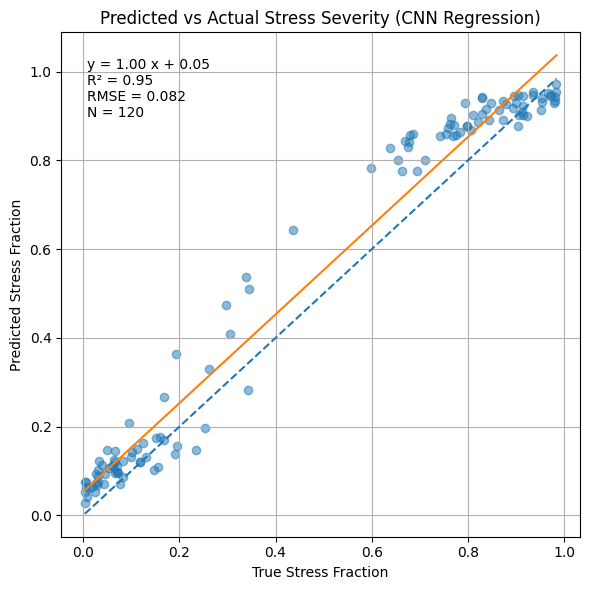

In [2]:
# continuous stress prediction
# stress severity prediction (fraction of stressed pixels)
# CNN-based Detection of Vegetation Stress from Satellite Imagery

# How the label is created
# How the model is compiled
# How the test set is evaluated

# Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE)

# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# pip install numpy tensorflow rasterio scikit-learn pandas

import os
import random
import numpy as np
from glob import glob
SEED = 42
# Environment-level determinism
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# Python & NumPy seeds
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label
BATCH_SIZE    = 8   # Model studies 8 images together at one time
EPOCHS        = 15   #Train the model on the entire dataset 15 times


splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]


#  list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths


# Loader: read 1..40 as features, 41 as label
# Change the label to a continuous target
# def load_single_patch(tif_path):
#     import numpy as np, rasterio, os

#     with rasterio.open(tif_path) as raster:
#         feature_bands_chw = raster.read(
#             indexes=list(range(1, NUM_BANDS + 1)),
#             out_dtype="float32"
#         )  # (40, H, W)

#         label_band_hw = raster.read(
#             LABEL_BAND,
#             out_dtype="float32"
#         )  # (H, W)

#         nodata_value = raster.nodata

#     # Replace NaNs and nodata with 0
#     feature_bands_chw = np.nan_to_num(feature_bands_chw)
#     label_band_hw = np.nan_to_num(label_band_hw)

#     if nodata_value is not None:
#         feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
#         label_band_hw[label_band_hw == nodata_value] = 0.0

#     feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
#     label_band_hw[label_band_hw < -1000.0] = 0.0

#     # Clip to reasonable ranges
#     feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
#     label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

#     # Majority label from label band
#     stressed_fraction = (label_band_hw >= 0.5).mean()
#     label_binary = 1 if stressed_fraction >= 0.5 else 0

#     # CHW to HWC
#     feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
#     if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
#         raise ValueError(
#             f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
#         )

#     return feature_bands_hwc, label_binary

# # Change the label to a continuous target
def load_single_patch(tif_path):
    import numpy as np, rasterio, os

    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # Continuous target: fraction of stressed pixels in the patch
    stressed_fraction = (label_band_hw >= 0.5).mean().astype("float32")
    patch_target = stressed_fraction   # in [0, 1]

    # CHW to HWC
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc, patch_target



# Build in-memory dataset for a split
# def load_split_dataset(split_name):
#     healthy_files  = list_patch_files(split_name, "healthy")
#     stressed_files = list_patch_files(split_name, "stressed")

#     file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
#     random.seed(SEED)  # ensure same order every run
#     random.shuffle(file_label_pairs)

#     dataset_list = []
#     skipped_count = 0

#     for tif_path, _ in file_label_pairs:
#         try:
#             image_array, patch_label = load_single_patch(tif_path)
#             dataset_list.append((image_array, patch_label))
#         except Exception as exception:
#             skipped_count += 1
#             print("Skipping", os.path.basename(tif_path), "-", exception)

#     label_values = [label for _, label in dataset_list]
#     count_healthy = label_values.count(0)
#     count_stressed = label_values.count(1)
#     print(
#         f"{split_name.capitalize()} loaded: {len(dataset_list)} "
#         f"(healthy={count_healthy}, stressed={count_stressed}, skipped={skipped_count})"
#     )

#     return dataset_list

def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "-", exception)

    # NEW summary for regression labels
    label_values = [label for _, label in dataset_list]

    print(
        f"{split_name.capitalize()} loaded: {len(dataset_list)} "
        f"(min_label={min(label_values):.3f}, "
        f"max_label={max(label_values):.3f}, "
        f"mean_label={np.mean(label_values):.3f}, skipped={skipped_count})"
    )

    return dataset_list


# Convert list of (image, label) into tf.data.Dataset
def create_tf_dataset(pairs_list):
    image_list = [image_array for image_array, _ in pairs_list]
    label_list = [label_value for _, label_value in pairs_list]

    image_array_all = np.asarray(image_list, dtype=np.float32)
    label_array_all = np.asarray(label_list, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_array_all, label_array_all))
    dataset = dataset.shuffle(2 * BATCH_SIZE, seed=SEED, reshuffle_each_iteration=False)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset



# CNN model
def build_cnn_model(input_shape, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Rescaling(1.0),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        # === Regression output: continuous stress score in [0, 1] ===
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model



# Main: load data, train, evaluate
print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = create_tf_dataset(train_pairs)
val_dataset   = create_tf_dataset(val_pairs)

print("Building CNN model...")
input_shape = (PATCH_HEIGHT, PATCH_WIDTH, NUM_BANDS)
cnn_model = build_cnn_model(input_shape=input_shape, dropout_rate=0.30)

# cnn_model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),   # regression loss
    metrics=[
        tf.keras.metrics.MeanSquaredError(name="mse"),
        tf.keras.metrics.MeanAbsoluteError(name="mae")
    ]
)



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Training CNN...")
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)


# # Evaluation on test set
# print("Evaluating on test set...")

# test_images = np.stack([image_array for image_array, _ in test_pairs], axis=0)
# test_labels = np.array([label_value for _, label_value in test_pairs], dtype=int)

# probabilities = cnn_model.predict(test_images, batch_size=BATCH_SIZE).ravel()
# predicted_labels = (probabilities >= 0.5).astype(int)
# accuracy_value  = accuracy_score(test_labels, predicted_labels)
# precision_value = precision_score(test_labels, predicted_labels, zero_division=0)
# recall_value    = recall_score(test_labels, predicted_labels, zero_division=0)
# f1_value        = f1_score(test_labels, predicted_labels, zero_division=0)
# confusion_mat   = confusion_matrix(test_labels, predicted_labels)

# metrics_dataframe = pd.DataFrame({
#     "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
#     "Score":  [accuracy_value, precision_value, recall_value, f1_value]
# })

# print("\nFinal evaluation metrics:")
# print(metrics_dataframe.to_string(index=False))
# print("\nConfusion Matrix:\n", confusion_mat)


# print("Evaluating on test set...")

# test_images = np.stack([image_array for image_array, _ in test_pairs], axis=0)
# test_targets = np.array([target_value for _, target_value in test_pairs], dtype=np.float32)

# predicted_scores = cnn_model.predict(test_images, batch_size=BATCH_SIZE).ravel()

# # Regression metrics
# mse_value = np.mean((predicted_scores - test_targets) ** 2)
# mae_value = np.mean(np.abs(predicted_scores - test_targets))
# rmse_value = np.sqrt(mse_value)

# metrics_dataframe = pd.DataFrame({
#     "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "Root Mean Squared Error (RMSE)"],
#     "Score":  [mse_value, mae_value, rmse_value]
# })

# print("\nFinal regression metrics:")
# print(metrics_dataframe.to_string(index=False))


print("Evaluating on test set...")

test_images = np.stack([image_array for image_array, _ in test_pairs], axis=0)
test_targets = np.array([target_value for _, target_value in test_pairs], dtype=np.float32)

predicted_scores = cnn_model.predict(test_images, batch_size=BATCH_SIZE).ravel()

# Regression metrics
mse_value  = np.mean((predicted_scores - test_targets) ** 2)
mae_value  = np.mean(np.abs(predicted_scores - test_targets))
rmse_value = np.sqrt(mse_value)
r2_value   = r2_score(test_targets, predicted_scores)

metrics_dataframe = pd.DataFrame({
    "Metric": [
        "Mean Squared Error (MSE)",
        "Mean Absolute Error (MAE)",
        "Root Mean Squared Error (RMSE)",
        "R² (Coefficient of Determination)"
    ],
    "Score":  [mse_value, mae_value, rmse_value, r2_value]
})

print("\nFinal regression metrics:")
print(metrics_dataframe.to_string(index=False))

# Scatter plot with regression line + stats (Massey-style)
# Fit linear regression: y = slope * x + intercept
slope, intercept = np.polyfit(test_targets, predicted_scores, 1)

min_value = float(min(test_targets.min(), predicted_scores.min()))
max_value = float(max(test_targets.max(), predicted_scores.max()))
x_line = np.linspace(min_value, max_value, 100)
y_line = slope * x_line + intercept

plt.figure(figsize=(6, 6))

# Scatter points
plt.scatter(test_targets, predicted_scores, alpha=0.5)

# 1:1 reference line (dashed)
plt.plot([min_value, max_value], [min_value, max_value],
         linestyle="--")

# Regression line (solid)
plt.plot(x_line, y_line)

plt.xlabel("True Stress Fraction")
plt.ylabel("Predicted Stress Fraction")
plt.title("Predicted vs Actual Stress Severity (CNN Regression)")

# Stats text in the corner (like the paper)
number_of_samples = len(test_targets)
stats_text = (
    f"y = {slope:.2f} x + {intercept:.2f}\n"
    f"R² = {r2_value:.2f}\n"
    f"RMSE = {rmse_value:.3f}\n"
    f"N = {number_of_samples}"
)

# Place text in axes coordinates (0–1)
plt.text(
    0.05, 0.95, stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_regression_scatter_stats.png", dpi=300)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Loading train/val/test datasets from split folders...
Train loaded: 420 (min_label=0.000, max_label=0.999, mean_label=0.478, skipped=0)
Val loaded: 60 (min_label=0.001, max_label=0.971, mean_label=0.464, skipped=0)
Test loaded: 120 (min_label=0.004, max_label=0.984, mean_label=0.473, skipped=0)
Building Vision Transformer model...
Training Vision Transformer (regression)...
Epoch [1/15] Train Loss: 0.0693 | Val Loss: 0.0372
Epoch [2/15] Train Loss: 0.0431 | Val Loss: 0.0340
Epoch [3/15] Train Loss: 0.0394 | Val Loss: 0.0328
Epoch [4/15] Train Loss: 0.0404 | Val Loss: 0.0346
Epoch [5/15] Train Loss: 0.0395 | Val Loss: 0.0379
Epoch [6/15] Train Loss: 0.0405 | Val Loss: 0.0377
Epoch [7/15] Train Loss: 0.0397 | Val Loss: 0.0362
Epoch [8/15] Train Loss: 0.0376 | Val Loss: 0.0412
Epoch [9/15] Train Loss: 0.0362 | Val Loss: 0.0331
Epoch [10/15] Tra

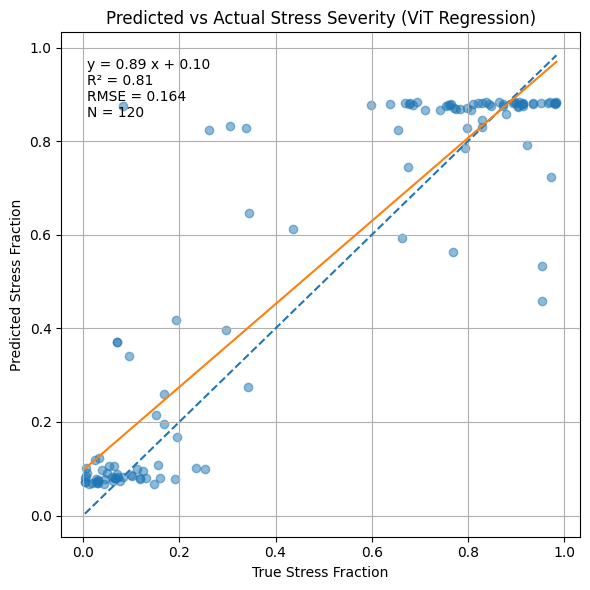

In [3]:
#  Vision Transformer Vegetation Stress Detection from Satellite Imagery (PyTorch ViT)
# Continuous stress prediction (fraction of stressed pixels in each patch)

# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# pip install torch torchvision numpy rasterio scikit-learn pandas

import os
import random
import numpy as np
import torch

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import rasterio
from sklearn.metrics import r2_score
import pandas as pd
import random
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label (1-based index)
BATCH_SIZE    = 8
EPOCHS        = 15

splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Helper: list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths

# === 1. Loader: read 1..40 as features, 41 as label (continuous fraction) ===
def load_single_patch(tif_path):
    import numpy as np, rasterio, os

    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to reasonable ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # Continuous target: fraction of stressed pixels in patch
    stressed_fraction = (label_band_hw >= 0.5).mean().astype("float32")
    patch_target = stressed_fraction  # in [0, 1]

    # CHW to HWC for storage; will convert to CHW in Dataset
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc.astype("float32"), patch_target

# === 2. Build in-memory dataset for a split (regression summary) ===
def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "->", exception)

    label_values = [label for _, label in dataset_list]
    print(
        f"{split_name.capitalize()} loaded: {len(dataset_list)} "
        f"(min_label={min(label_values):.3f}, "
        f"max_label={max(label_values):.3f}, "
        f"mean_label={np.mean(label_values):.3f}, skipped={skipped_count})"
    )

    return dataset_list

# PyTorch Dataset
class PatchDataset(Dataset):
    def __init__(self, pairs_list):
        self.image_list = [image_array for image_array, _ in pairs_list]
        self.label_list = [label_value for _, label_value in pairs_list]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_array = self.image_list[index]          # H, W, C
        label_value = self.label_list[index]

        # Convert to tensor, HWC -> CHW
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)  # C, H, W
        label_tensor = torch.tensor(label_value, dtype=torch.float32)  # scalar in [0,1]

        return image_tensor, label_tensor

# Vision Transformer components
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_ratio=2.0, dropout_rate=0.3):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=False  # expects (seq_len, batch, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        hidden_dim = int(embedding_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embedding_dim),
        )

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (batch, num_patches, embedding_dim)
        residual = x
        x_norm = self.norm1(x)
        x_transposed = x_norm.transpose(0, 1)  # (num_patches, batch, embed_dim)
        attention_output, _ = self.attention(x_transposed, x_transposed, x_transposed)
        attention_output = attention_output.transpose(0, 1)  # back to (batch, num_patches, embedding_dim)
        x = residual + self.dropout(attention_output)

        residual2 = x
        x_norm2 = self.norm2(x)
        mlp_output = self.mlp(x_norm2)
        x = residual2 + self.dropout(mlp_output)
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
                 image_height,
                 image_width,
                 num_channels,
                 patch_size=8,
                 embedding_dim=64,
                 num_layers=4,
                 num_heads=4,
                 mlp_ratio=3.0,
                 dropout_rate=0.3,
                 mlp_head_units=(128, 64)):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.num_channels = num_channels
        self.patch_size = patch_size

        assert image_height % patch_size == 0 and image_width % patch_size == 0, \
            "Image size must be divisible by patch size."

        self.num_patches_h = image_height // patch_size
        self.num_patches_w = image_width // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        # Patch embedding via Conv2d
        self.patch_embedding = nn.Conv2d(
            in_channels=num_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Positional embeddings
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.num_patches, embedding_dim)
        )

        # Transformer encoder blocks
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embedding_dim)

        # Regression head (will output score in [0,1])
        mlp_head = []
        current_dim = embedding_dim
        for units in mlp_head_units:
            mlp_head.append(nn.Linear(current_dim, units))
            mlp_head.append(nn.ReLU())
            mlp_head.append(nn.Dropout(dropout_rate))
            current_dim = units
        mlp_head.append(nn.Linear(current_dim, 1))  # single scalar
        self.mlp_head = nn.Sequential(*mlp_head)

    def forward(self, images):
        # images: (batch, C, H, W)
        x = self.patch_embedding(images)  # (batch, embedding_dim, H/ps, W/ps)
        batch_size, embedding_dim, patches_h, patches_w = x.shape
        x = x.reshape(batch_size, embedding_dim, patches_h * patches_w)
        x = x.permute(0, 2, 1)  # (batch, num_patches, embedding_dim)

        x = x + self.position_embeddings  # add positional info

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)

        x = self.norm(x)

        # Global average pooling over patches
        x = x.mean(dim=1)  # (batch, embedding_dim)

        logits = self.mlp_head(x)          # (batch, 1)
        scores = torch.sigmoid(logits)     # map to [0, 1] for regression target
        return scores

# Load data
print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = PatchDataset(train_pairs)
val_dataset   = PatchDataset(val_pairs)
test_dataset  = PatchDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Build Vision Transformer model
print("Building Vision Transformer model...")
vit_model = VisionTransformer(
    image_height=PATCH_HEIGHT,
    image_width=PATCH_WIDTH,
    num_channels=NUM_BANDS,
    patch_size=8,
    embedding_dim=64,
    num_layers=4,
    num_heads=4,
    mlp_ratio=3.0,
    dropout_rate=0.30,
    mlp_head_units=(128, 64)
).to(device)

#  Regression loss instead of BCEWithLogits
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-3)

# Training loop with early stopping
best_val_loss = float("inf")
epochs_without_improvement = 0
best_model_state = None

print("Training Vision Transformer (regression)...")

for epoch_index in range(EPOCHS):
    vit_model.train()
    running_train_loss = 0.0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).unsqueeze(1)  # (batch, 1)

        optimizer.zero_grad()
        scores = vit_model(batch_images)          # scores in [0,1]
        loss = criterion(scores, batch_labels)    # MSE
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_images.size(0)

    average_train_loss = running_train_loss / len(train_dataset)

    # Validation
    vit_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).unsqueeze(1)

            val_scores = vit_model(val_images)
            val_loss = criterion(val_scores, val_labels)
            running_val_loss += val_loss.item() * val_images.size(0)

    average_val_loss = running_val_loss / len(val_dataset)

    print(
        f"Epoch [{epoch_index + 1}/{EPOCHS}] "
        f"Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}"
    )

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_without_improvement = 0
        best_model_state = vit_model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 10:
            print("Early stopping triggered.")
            break

# Load best model weights
if best_model_state is not None:
    vit_model.load_state_dict(best_model_state)

# === 4. Evaluation on test set (MSE, MAE, RMSE, R² + scatter) ===
print("Evaluating on test set...")

vit_model.eval()
all_scores = []
all_true_targets = []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        scores_batch = vit_model(test_images).cpu().numpy().ravel()   # predicted stress fraction
        all_scores.extend(scores_batch)
        all_true_targets.extend(test_labels.numpy().tolist())

all_scores = np.array(all_scores, dtype=np.float32)
all_true_targets = np.array(all_true_targets, dtype=np.float32)

mse_value  = np.mean((all_scores - all_true_targets) ** 2)
mae_value  = np.mean(np.abs(all_scores - all_true_targets))
rmse_value = np.sqrt(mse_value)
r2_value   = r2_score(all_true_targets, all_scores)

metrics_dataframe = pd.DataFrame({
    "Metric": [
        "Mean Squared Error (MSE)",
        "Mean Absolute Error (MAE)",
        "Root Mean Squared Error (RMSE)",
        "R² (Coefficient of Determination)"
    ],
    "Score":  [mse_value, mae_value, rmse_value, r2_value]
})

print("\nFinal regression metrics (ViT):")
print(metrics_dataframe.to_string(index=False))


# Scatter plot with regression line + stats (ViT, Massey-style)
# Fit linear regression: y = slope * x + intercept
slope, intercept = np.polyfit(all_true_targets, all_scores, 1)

min_value = float(min(all_true_targets.min(), all_scores.min()))
max_value = float(max(all_true_targets.max(), all_scores.max()))
x_line = np.linspace(min_value, max_value, 100)
y_line = slope * x_line + intercept

plt.figure(figsize=(6, 6))

# Scatter points
plt.scatter(all_true_targets, all_scores, alpha=0.5)

# 1:1 reference line (dashed)
plt.plot([min_value, max_value], [min_value, max_value],
         linestyle="--")

# Regression line (solid)
plt.plot(x_line, y_line)

plt.xlabel("True Stress Fraction")
plt.ylabel("Predicted Stress Fraction")
plt.title("Predicted vs Actual Stress Severity (ViT Regression)")

# Stats text in the corner
number_of_samples = len(all_true_targets)
stats_text = (
    f"y = {slope:.2f} x + {intercept:.2f}\n"
    f"R² = {r2_value:.2f}\n"
    f"RMSE = {rmse_value:.3f}\n"
    f"N = {number_of_samples}"
)

plt.text(
    0.05, 0.95, stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.grid(True)
plt.tight_layout()
plt.savefig("vit_regression_scatter.png", dpi=300)
plt.show()


In [4]:
!pip install -U transformers

In [5]:
!pip install rasterio --quiet

Using device: cuda
Mounted at /content/drive
Loading train/val/test datasets from split folders...
Train loaded: 420 (healthy=210, stressed=210, skipped=0)
Val loaded: 60 (healthy=30, stressed=30, skipped=0)
Test loaded: 120 (healthy=60, stressed=60, skipped=0)
Building DINOv2-based model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2Model were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 14, 14]) in the checkpoint and torch.Size([768, 40, 14, 14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resizing positional embeddings: 1369 to 64
Training DINOv2 classifier...
Epoch [1/15] Train Loss: 1.0239 | Val Loss: 0.6919
Epoch [2/15] Train Loss: 0.7345 | Val Loss: 0.7254
Epoch [3/15] Train Loss: 0.7347 | Val Loss: 0.6889
Epoch [4/15] Train Loss: 0.7259 | Val Loss: 0.6816
Epoch [5/15] Train Loss: 0.7557 | Val Loss: 0.7053
Epoch [6/15] Train Loss: 0.7198 | Val Loss: 0.7256
Epoch [7/15] Train Loss: 0.6324 | Val Loss: 0.4836
Epoch [8/15] Train Loss: 0.5073 | Val Loss: 0.6951
Epoch [9/15] Train Loss: 0.5027 | Val Loss: 0.5756
Epoch [10/15] Train Loss: 0.6521 | Val Loss: 0.5979
Epoch [11/15] Train Loss: 0.4375 | Val Loss: 0.3971
Epoch [12/15] Train Loss: 0.3444 | Val Loss: 0.3792
Epoch [13/15] Train Loss: 0.3522 | Val Loss: 0.3441
Epoch [14/15] Train Loss: 0.3506 | Val Loss: 0.5868
Epoch [15/15] Train Loss: 0.3804 | Val Loss: 0.2877
Evaluating on test set...

Final evaluation metrics (DINOv2, 64×64, 40 bands):
   Metric    Score
 Accuracy 0.941667
Precision 0.920635
   Recall 0.966667
 

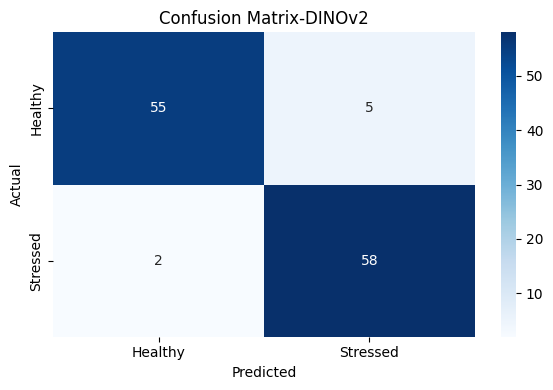

In [1]:
# DINOv2-based Vegetation Stress Detection from Sentinel-2 (PyTorch, Hugging Face)
# https://huggingface.co/facebook/dinov2-base
# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# pip install torch torchvision numpy rasterio scikit-learn pandas transformers

import os
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from google.colab import drive
from transformers import AutoConfig, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label (1-based index)
BATCH_SIZE    = 8
EPOCHS        = 15

# 64×64 patches, 8×8 patch size
DINO_IMAGE_RES  = 64
DINO_PATCH_SIZE = 8      #  8×8 = 64 tokens

splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Mount Google Drive
drive.mount('/content/drive')
#list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths

# Loader: read 1..40 as features, 41 as label (majority)
def load_single_patch(tif_path):
    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to reasonable ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # Majority label from label band
    stressed_fraction = (label_band_hw >= 0.5).mean()
    label_binary = 1 if stressed_fraction >= 0.5 else 0

    # CHW to HWC for storage; will convert to CHW in Dataset
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc.astype("float32"), label_binary


# Build in-memory dataset for a split
def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "to", exception)

    label_values = [label for _, label in dataset_list]
    count_healthy = label_values.count(0)
    count_stressed = label_values.count(1)
    print(
        f"{split_name.capitalize()} loaded: {len(dataset_list)} "
        f"(healthy={count_healthy}, stressed={count_stressed}, skipped={skipped_count})"
    )

    return dataset_list


# PyTorch Dataset
class PatchDataset(Dataset):
    def __init__(self, pairs_list):
        self.image_list = [image_array for image_array, _ in pairs_list]
        self.label_list = [label_value for _, label_value in pairs_list]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_array = self.image_list[index]          # H, W, C
        label_value = self.label_list[index]

        # HWC to CHW
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)  # (C, 64, 64)
        label_tensor = torch.tensor(label_value, dtype=torch.float32)

        return image_tensor, label_tensor


# DINOv2-based classifier (40 bands, 64×64, patch size 8)
class DINOv2Classifier(nn.Module):
    def __init__(self, input_channels=NUM_BANDS,
                 image_res=DINO_IMAGE_RES,
                 patch_size=DINO_PATCH_SIZE):
        super().__init__()

        # Load and modify config
        config = AutoConfig.from_pretrained("facebook/dinov2-base")
        config.num_channels = input_channels  # change from 3 to 40

        # Load model with modified config, allowing mismatch in input projection
        self.encoder = AutoModel.from_pretrained(
            "facebook/dinov2-base",
            config=config,
            ignore_mismatched_sizes=True
        )

        hidden_dim = config.hidden_size  # 768 for dinov2-base

        # Replace the patch embedding layer to use 40 bands and patch_size=8
        self.encoder.embeddings.patch_embeddings.projection = nn.Conv2d(
            input_channels,
            hidden_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Resize positional embeddings: old grid to new (64/8)×(64/8) = 8×8 tokens
        if hasattr(self.encoder.embeddings, "position_embeddings"):
            old_posemb = self.encoder.embeddings.position_embeddings  # (1, N_old+1, D)
            cls_token = old_posemb[:, :1, :]
            patch_posemb = old_posemb[:, 1:, :]
            N_old = patch_posemb.shape[1]

            N_new = (image_res // patch_size) ** 2  # (64/8)^2 = 64

            # N_old = number of patch positions DINOv2 was originally trained for (e.g. 196)
            # N_new = number of patch positions in my setup (64)

            if N_old != N_new:
                print(f"Resizing positional embeddings: {N_old} to {N_new}")
                dim = patch_posemb.shape[-1]
                #   # If N_old = 196, then root(196) = 14 , old grid is 14×14
                h_old = w_old = int(N_old ** 0.5)
                #  # If N_new = 64, then root(64) = 8, new grid is 8×8
                h_new = w_new = int(N_new ** 0.5)

                # # (1, 14, 14, 768) to (1, 768, 14, 14) as permute(0, 3, 1, 2)
                patch_posemb = patch_posemb.reshape(1, h_old, w_old, dim).permute(0, 3, 1, 2)
                #   F.interpolate expects data like image tensors (batch, channels, height, width)
                # (1, 768, 14, 14) to (1, 768, 8, 8)
                # resizing an image from 14×14 to 8×8 using bilinear interpolation
                patch_posemb = F.interpolate(
                    patch_posemb, size=(h_new, w_new),
                    mode='bilinear', align_corners=False
                )

                # permute(0, 2, 3, 1)
                # from (1, 768, 8, 8) to (1, 8, 8, 768).
                # reshape(1, N_new, dim)
                # from (1, 8, 8, 768) to (1, 64, 768)
                # because 8×8 = 64 = N_new
                patch_posemb = patch_posemb.permute(0, 2, 3, 1).reshape(1, N_new, dim)
                #cls_token shape (1, 1, 768)
                # +
                # patch_posemb shape (1, 64, 768)
                # -----------------------------------
                # new_posemb   shape (1, 65, 768)
                # [CLS POSITION | PATCH POSITION 1 | PATCH POSITION 2 | ... | PATCH POSITION 64]
                new_posemb = torch.cat([cls_token, patch_posemb], dim=1)
                # Use the new positional embeddings I made, not the old ones
                self.encoder.embeddings.position_embeddings = nn.Parameter(new_posemb)

        # Simple classification head on CLS token
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 1)  # single logit
        )

    def forward(self, x):
        # x: (B, C, 64, 64)
        outputs = self.encoder(pixel_values=x, return_dict=True)
        # [:, 0] means: For every item in batch, take token at position 0
        cls_token = outputs.last_hidden_state[:, 0]   # CLS token
        # CLS goes into head (LayerNorm + Linear)
        # Linear reduces 768 to 1 number (logit)
        # WE get 1 number per image in batch
        # Shape goes from: (8, 768) to (8, 1) to (8,)
        # 8 values
        # One value per sample in the batch
        # Why do we want (B,) instead of (B,1)
        # many loss functions and metrics expect a 1D vector, not a 2D matrix.
        logits = self.head(cls_token).squeeze(1)      # (B,)
        return logits


# Load data
print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = PatchDataset(train_pairs)
val_dataset   = PatchDataset(val_pairs)
test_dataset  = PatchDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# Build DINOv2 model
print("Building DINOv2-based model...")
model = DINOv2Classifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training loop with early stopping
best_val_loss = float("inf")
epochs_without_improvement = 0
best_model_state = None

print("Training DINOv2 classifier...")

for epoch_index in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        logits = model(batch_images)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_images.size(0)

    average_train_loss = running_train_loss / len(train_dataset)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_logits = model(val_images)
            val_loss = criterion(val_logits, val_labels)
            running_val_loss += val_loss.item() * val_images.size(0)

    average_val_loss = running_val_loss / len(val_dataset)

    print(
        f"Epoch [{epoch_index + 1}/{EPOCHS}] "
        f"Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}"
    )

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 10:  # patience
            print("Early stopping triggered.")
            break

# Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)


# Evaluation on test set

print("Evaluating on test set...")

model.eval()
all_probabilities = []
all_true_labels = []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        logits = model(test_images)
        probabilities_batch = torch.sigmoid(logits).cpu().numpy().ravel()
        all_probabilities.extend(probabilities_batch)
        all_true_labels.extend(test_labels.numpy().tolist())

all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels).astype(int)

predicted_labels = (all_probabilities >= 0.5).astype(int)

accuracy_value  = accuracy_score(all_true_labels, predicted_labels)
precision_value = precision_score(all_true_labels, predicted_labels, zero_division=0)
recall_value    = recall_score(all_true_labels, predicted_labels, zero_division=0)
f1_value        = f1_score(all_true_labels, predicted_labels, zero_division=0)
confusion_mat   = confusion_matrix(all_true_labels, predicted_labels)

metrics_dataframe = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score":  [accuracy_value, precision_value, recall_value, f1_value]
})

print("\nFinal evaluation metrics (DINOv2, 64×64, 40 bands):")
print(metrics_dataframe.to_string(index=False))
print("\nConfusion Matrix:\n", confusion_mat)


# Plot and save confusion matrix

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Stressed"],
            yticklabels=["Healthy", "Stressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix-DINOv2")
plt.tight_layout()
plt.savefig("confusion_matrix_DINOv2.png", dpi=300)
plt.show()


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading train/val/test datasets from split folders...
Train loaded: 420 (min_label=0.000, max_label=0.999, mean_label=0.478, skipped=0)
Val loaded: 60 (min_label=0.001, max_label=0.971, mean_label=0.464, skipped=0)


Some weights of Dinov2Model were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 14, 14]) in the checkpoint and torch.Size([768, 40, 14, 14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test loaded: 120 (min_label=0.004, max_label=0.984, mean_label=0.473, skipped=0)
Building DINOv2-based regression model...
Resizing positional embeddings: 1369 to 64
Training DINOv2 regressor...
Epoch [1/15] Train Loss: 0.1169 | Val Loss: 0.0466
Epoch [2/15] Train Loss: 0.0431 | Val Loss: 0.0693
Epoch [3/15] Train Loss: 0.0558 | Val Loss: 0.0499
Epoch [4/15] Train Loss: 0.0404 | Val Loss: 0.0375
Epoch [5/15] Train Loss: 0.0391 | Val Loss: 0.0323
Epoch [6/15] Train Loss: 0.0360 | Val Loss: 0.0389
Epoch [7/15] Train Loss: 0.0348 | Val Loss: 0.0389
Epoch [8/15] Train Loss: 0.0396 | Val Loss: 0.0628
Epoch [9/15] Train Loss: 0.0394 | Val Loss: 0.0317
Epoch [10/15] Train Loss: 0.0321 | Val Loss: 0.0298
Epoch [11/15] Train Loss: 0.0313 | Val Loss: 0.0269
Epoch [12/15] Train Loss: 0.0306 | Val Loss: 0.0399
Epoch [13/15] Train Loss: 0.0400 | Val Loss: 0.0357
Epoch [14/15] Train Loss: 0.0385 | Val Loss: 0.0338
Epoch [15/15] Train Loss: 0.0348 | Val Loss: 0.0265
Evaluating on test set...

Final r

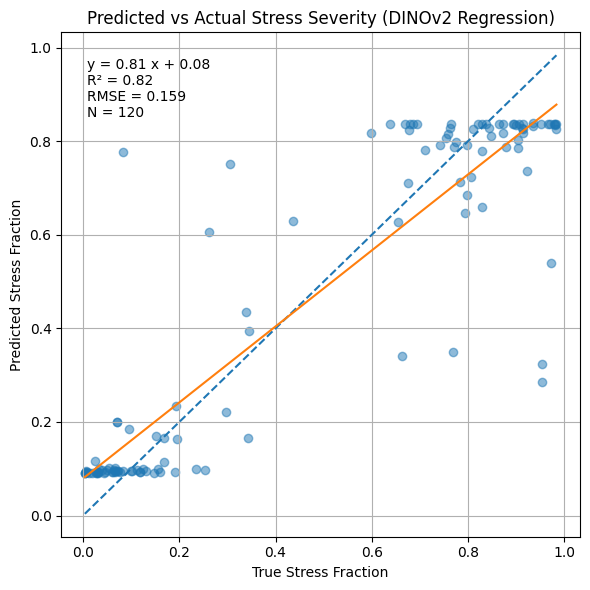

In [2]:
# DINOv2-based Vegetation Stress Regression from Sentinel-2 (PyTorch, Hugging Face)
# Continuous stress prediction: fraction of stressed pixels in each patch
# https://huggingface.co/facebook/dinov2-base
# Uses pre-split data in:
# /content/drive/MyDrive/Sentinel2_Split_23_25/{train,val,test}/{healthy,stressed}

# pip install torch torchvision numpy rasterio scikit-learn pandas transformers

import os
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio
from sklearn.metrics import r2_score
import pandas as pd
from google.colab import drive
from transformers import AutoConfig, AutoModel
import matplotlib.pyplot as plt


# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# CONFIG
BASE_FOLDER   = "/content/drive/MyDrive/Sentinel2_Split_23_25"   # train/val/test live here
PATCH_HEIGHT  = 64
PATCH_WIDTH   = 64
NUM_BANDS     = 40      # first 40 bands are features
LABEL_BAND    = 41      # last band is label (1-based index)
BATCH_SIZE    = 8
EPOCHS        = 15

# 64×64 patches, 8×8 patch size
DINO_IMAGE_RES  = 64
DINO_PATCH_SIZE = 8      # 8×8 = 64 tokens

splits  = ["train", "val", "test"]
classes = ["healthy", "stressed"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Mount Google Drive
drive.mount('/content/drive')


# list patch files for a split + class
def list_patch_files(split_name, class_name):
    split_folder = os.path.join(BASE_FOLDER, split_name, class_name)
    file_paths = sorted(glob(os.path.join(split_folder, "*.tif")))
    return file_paths


# Loader: read 1..40 as features, 41 as label (continuous fraction)
def load_single_patch(tif_path):
    with rasterio.open(tif_path) as raster:
        feature_bands_chw = raster.read(
            indexes=list(range(1, NUM_BANDS + 1)),
            out_dtype="float32"
        )  # (40, H, W)

        label_band_hw = raster.read(
            LABEL_BAND,
            out_dtype="float32"
        )  # (H, W)

        nodata_value = raster.nodata

    # Replace NaNs and nodata with 0
    feature_bands_chw = np.nan_to_num(feature_bands_chw)
    label_band_hw = np.nan_to_num(label_band_hw)

    if nodata_value is not None:
        feature_bands_chw[feature_bands_chw == nodata_value] = 0.0
        label_band_hw[label_band_hw == nodata_value] = 0.0

    feature_bands_chw[feature_bands_chw < -1000.0] = 0.0
    label_band_hw[label_band_hw < -1000.0] = 0.0

    # Clip to reasonable ranges
    feature_bands_chw = np.clip(feature_bands_chw, -1.0, 1.0)
    label_band_hw = np.clip(label_band_hw, 0.0, 1.0)  # 0 = healthy, 1 = stressed

    # ===== Continuous target: fraction of stressed pixels in patch =====
    stressed_fraction = (label_band_hw >= 0.5).mean().astype("float32")
    patch_target = stressed_fraction  # in [0, 1]

    # CHW to HWC for storage; will convert to CHW in Dataset
    feature_bands_hwc = feature_bands_chw.transpose(1, 2, 0)
    if feature_bands_hwc.shape[:2] != (PATCH_HEIGHT, PATCH_WIDTH):
        raise ValueError(
            f"Unexpected patch size {feature_bands_hwc.shape[:2]} in {os.path.basename(tif_path)}"
        )

    return feature_bands_hwc.astype("float32"), patch_target


# Build in-memory dataset for a split (regression summary)

def load_split_dataset(split_name):
    healthy_files  = list_patch_files(split_name, "healthy")
    stressed_files = list_patch_files(split_name, "stressed")

    file_label_pairs = [(path, 0) for path in healthy_files] + [(path, 1) for path in stressed_files]
    random.seed(SEED)
    random.shuffle(file_label_pairs)

    dataset_list = []
    skipped_count = 0

    for tif_path, _ in file_label_pairs:
        try:
            image_array, patch_label = load_single_patch(tif_path)
            dataset_list.append((image_array, patch_label))
        except Exception as exception:
            skipped_count += 1
            print("Skipping", os.path.basename(tif_path), "to", exception)

    label_values = [label for _, label in dataset_list]
    if len(label_values) > 0:
        print(
            f"{split_name.capitalize()} loaded: {len(dataset_list)} "
            f"(min_label={min(label_values):.3f}, "
            f"max_label={max(label_values):.3f}, "
            f"mean_label={np.mean(label_values):.3f}, skipped={skipped_count})"
        )
    else:
        print(f"{split_name.capitalize()} loaded: 0 (skipped={skipped_count})")

    return dataset_list


# PyTorch Dataset

class PatchDataset(Dataset):
    def __init__(self, pairs_list):
        self.image_list = [image_array for image_array, _ in pairs_list]
        self.label_list = [label_value for _, label_value in pairs_list]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_array = self.image_list[index]          # H, W, C
        label_value = self.label_list[index]

        # HWC to CHW
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)  # (C, 64, 64)
        label_tensor = torch.tensor(label_value, dtype=torch.float32)  # scalar in [0,1]

        return image_tensor, label_tensor


# DINOv2-based regressor (40 bands, 64×64, patch size 8)

class DINOv2Regressor(nn.Module):
    def __init__(self, input_channels=NUM_BANDS,
                 image_res=DINO_IMAGE_RES,
                 patch_size=DINO_PATCH_SIZE):
        super().__init__()

        # Load and modify config
        config = AutoConfig.from_pretrained("facebook/dinov2-base")
        config.num_channels = input_channels  # change from 3 to 40

        # Load model with modified config, allowing mismatch in input projection
        self.encoder = AutoModel.from_pretrained(
            "facebook/dinov2-base",
            config=config,
            ignore_mismatched_sizes=True
        )

        hidden_dim = config.hidden_size  # 768 for dinov2-base

        # Replace the patch embedding layer to use 40 bands and patch_size=8
        self.encoder.embeddings.patch_embeddings.projection = nn.Conv2d(
            input_channels,
            hidden_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Resize positional embeddings: old grid to new (64/8)×(64/8) = 8×8 tokens
        if hasattr(self.encoder.embeddings, "position_embeddings"):
            old_posemb = self.encoder.embeddings.position_embeddings  # (1, N_old+1, D)
            cls_token = old_posemb[:, :1, :]
            patch_posemb = old_posemb[:, 1:, :]
            N_old = patch_posemb.shape[1]

            N_new = (image_res // patch_size) ** 2  # (64/8)^2 = 64
            if N_old != N_new:
                print(f"Resizing positional embeddings: {N_old} to {N_new}")
                dim = patch_posemb.shape[-1]
                h_old = w_old = int(N_old ** 0.5)
                h_new = w_new = int(N_new ** 0.5)

                patch_posemb = patch_posemb.reshape(1, h_old, w_old, dim).permute(0, 3, 1, 2)
                patch_posemb = F.interpolate(
                    patch_posemb, size=(h_new, w_new),
                    mode='bilinear', align_corners=False
                )
                patch_posemb = patch_posemb.permute(0, 2, 3, 1).reshape(1, N_new, dim)
                new_posemb = torch.cat([cls_token, patch_posemb], dim=1)
                self.encoder.embeddings.position_embeddings = nn.Parameter(new_posemb)

        # Regression head on CLS token
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 1)  # single scalar
        )

    def forward(self, x):
        # x: (B, C, 64, 64)
        outputs = self.encoder(pixel_values=x, return_dict=True)
        cls_token = outputs.last_hidden_state[:, 0]   # CLS token
        logits = self.head(cls_token).squeeze(1)      # (B,)
        scores = torch.sigmoid(logits)                # map to [0,1]
        return scores


# Load data

print("Loading train/val/test datasets from split folders...")
train_pairs = load_split_dataset("train")
val_pairs   = load_split_dataset("val")
test_pairs  = load_split_dataset("test")

if len(train_pairs) == 0 or len(val_pairs) == 0 or len(test_pairs) == 0:
    raise RuntimeError("Train/val/test split has empty set. Check your split folders.")

train_dataset = PatchDataset(train_pairs)
val_dataset   = PatchDataset(val_pairs)
test_dataset  = PatchDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# Build DINOv2 regression model

print("Building DINOv2-based regression model...")
model = DINOv2Regressor().to(device)

# Regression loss instead of BCE
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)


# Training loop with early stopping

best_val_loss = float("inf")
epochs_without_improvement = 0
best_model_state = None

print("Training DINOv2 regressor...")

for epoch_index in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device).unsqueeze(1)  # (batch, 1)

        optimizer.zero_grad()
        scores = model(batch_images).unsqueeze(1)   # (batch, 1), scores in [0,1]
        loss = criterion(scores, batch_labels)      # MSE
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_images.size(0)

    average_train_loss = running_train_loss / len(train_dataset)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).unsqueeze(1)

            val_scores = model(val_images).unsqueeze(1)
            val_loss = criterion(val_scores, val_labels)
            running_val_loss += val_loss.item() * val_images.size(0)

    average_val_loss = running_val_loss / len(val_dataset)

    print(
        f"Epoch [{epoch_index + 1}/{EPOCHS}] "
        f"Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}"
    )

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 10:
            print("Early stopping triggered.")
            break

# Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)


# Evaluation on test set (MSE, MAE, RMSE, R² + scatter)
print("Evaluating on test set...")

model.eval()
all_scores = []
all_true_targets = []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        scores_batch = model(test_images).cpu().numpy().ravel()   # predicted stress fraction
        all_scores.extend(scores_batch)
        all_true_targets.extend(test_labels.numpy().tolist())

all_scores = np.array(all_scores, dtype=np.float32)
all_true_targets = np.array(all_true_targets, dtype=np.float32)

mse_value  = np.mean((all_scores - all_true_targets) ** 2)
mae_value  = np.mean(np.abs(all_scores - all_true_targets))
rmse_value = np.sqrt(mse_value)
r2_value   = r2_score(all_true_targets, all_scores)

metrics_dataframe = pd.DataFrame({
    "Metric": [
        "Mean Squared Error (MSE)",
        "Mean Absolute Error (MAE)",
        "Root Mean Squared Error (RMSE)",
        "R² (Coefficient of Determination)"
    ],
    "Score":  [mse_value, mae_value, rmse_value, r2_value]
})

print("\nFinal regression metrics (DINOv2, 64×64, 40 bands):")
print(metrics_dataframe.to_string(index=False))


# Scatter plot: Predicted vs Actual stress fraction
slope, intercept = np.polyfit(all_true_targets, all_scores, 1)

min_value = float(min(all_true_targets.min(), all_scores.min()))
max_value = float(max(all_true_targets.max(), all_scores.max()))
x_line = np.linspace(min_value, max_value, 100)
y_line = slope * x_line + intercept

plt.figure(figsize=(6, 6))

plt.scatter(all_true_targets, all_scores, alpha=0.5)

# 1:1 reference line (dashed)
plt.plot([min_value, max_value], [min_value, max_value],
         linestyle="--")

# Regression line (solid)
plt.plot(x_line, y_line)

plt.xlabel("True Stress Fraction")
plt.ylabel("Predicted Stress Fraction")
plt.title("Predicted vs Actual Stress Severity (DINOv2 Regression)")

number_of_samples = len(all_true_targets)
stats_text = (
    f"y = {slope:.2f} x + {intercept:.2f}\n"
    f"R² = {r2_value:.2f}\n"
    f"RMSE = {rmse_value:.3f}\n"
    f"N = {number_of_samples}"
)

plt.text(
    0.05, 0.95, stats_text,
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

plt.grid(True)
plt.tight_layout()
plt.savefig("dino_regression_scatter.png", dpi=300)
plt.show()
